In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.metrics import mean_absolute_error as mae
from pandas.tseries.offsets import BDay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [3]:
df_main = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stock Market/TESLA.csv')
df_main.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-16,45.098000,45.438000,44.681999,44.722000,44.722000,11335500
1,2016-08-17,44.866001,44.966000,44.560001,44.647999,44.647999,8935500
2,2016-08-18,44.764000,45.132000,44.458000,44.702000,44.702000,8572500
3,2016-08-19,44.708000,45.034000,44.506001,45.000000,45.000000,8297500
4,2016-08-22,44.834000,45.021999,44.535999,44.585999,44.585999,10327500


In [4]:
df_main.shape

(1258, 7)

In [5]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [6]:
time = pd.date_range(start='16/08/2016',periods=1258,freq=BDay())
df_main['time_stamp'] = pd.DataFrame(time)
df_main.drop(['Date'],axis=1,inplace=True)
df_main = df_main.set_index('time_stamp')

In [7]:
df = df_main[['Close']]

In [ ]:
df.head()

,Close
time_stamp,
2016-08-16,44.722000
2016-08-17,44.647999
2016-08-18,44.702000
2016-08-19,45.000000
2016-08-22,44.585999


In [ ]:
df.tail()

,Close
time_stamp,
2021-06-04,713.760010
2021-06-07,709.989990
2021-06-08,707.820007
2021-06-09,722.250000
2021-06-10,717.169983


In [8]:
plt.rcParams['figure.figsize'] = [15,8]

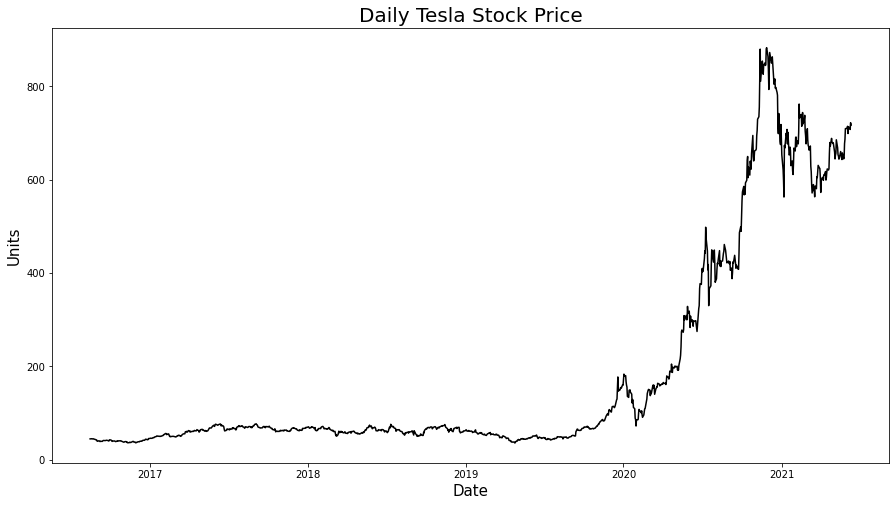

In [9]:
plt.plot(df,color='black')
plt.title('Daily Tesla Stock Price',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [10]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [30]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['Close'] = df['Close'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [31]:
#Split data set into testing dataset and train dataset
train_size = 1132
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 4
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
# reshape input to be [samples, window size, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1128, 1, 4)
(1128,)
(122, 1, 4)
(122,)


In [14]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.4 MB/s 


In [15]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [16]:
def build_model(hp):
    model = keras.Sequential()
    model.add(LSTM(hp.Int('rnn_layer_1',min_value=16,max_value=256,step=8), activation="relu", input_shape=(1,look_back),recurrent_dropout = hp.Choice("recurrent_dropout",[0.2,0.3,0.4],default=0.2)))
    model.add(Dense(hp.Int('dense_layer_1',min_value=16,max_value=256,step=8),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-3, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [17]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=20,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_3')

In [18]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
rnn_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 8, 'sampling': None}
recurrent_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
dense_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 8, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [19]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=34,
             validation_data=(testX, testY))

Trial 20 Complete [00h 00m 43s]
val_mape: 2.2607991695404053

Best val_mape So Far: 2.241626739501953
Total elapsed time: 00h 20m 58s
INFO:tensorflow:Oracle triggered exit


In [20]:
tuner.results_summary()

Results summary
Results in project/loa_em_3
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
rnn_layer_1: 224
recurrent_dropout: 0.4
dense_layer_1: 112
Dropout_rate: 0.1
learning_rate: 0.014835474564790459
Score: 2.241626739501953
Trial summary
Hyperparameters:
rnn_layer_1: 80
recurrent_dropout: 0.4
dense_layer_1: 240
Dropout_rate: 0.2
learning_rate: 0.012997357216057845
Score: 2.2464988231658936
Trial summary
Hyperparameters:
rnn_layer_1: 48
recurrent_dropout: 0.3
dense_layer_1: 208
Dropout_rate: 0.2
learning_rate: 0.01565283522619813
Score: 2.2607991695404053
Trial summary
Hyperparameters:
rnn_layer_1: 192
recurrent_dropout: 0.2
dense_layer_1: 48
Dropout_rate: 0.2
learning_rate: 0.02208700298172279
Score: 2.263029098510742
Trial summary
Hyperparameters:
rnn_layer_1: 80
recurrent_dropout: 0.4
dense_layer_1: 160
Dropout_rate: 0.30000000000000004
learning_rate: 0.003730278430367326
Score: 2.268097162246704
Trial summary
Hyperparameters:
r

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [21]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 4))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 224)               205184    
                                                                 
 dense (Dense)               (None, 112)               25200     
                                                                 
 dropout (Dropout)           (None, 112)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 113       
                                                                 
Total params: 230,497
Trainable params: 230,497
Non-trainable params: 0
_________________________________________________________________


In [22]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
model = Sequential()
model.add(LSTM(256,activation='relu',input_dim = 4,recurrent_dropout=0.3,return_sequences=True))
model.add(LSTM(128,activation='relu',recurrent_dropout=0.3))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate = 0.000014835474564790459)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 34, epochs = 500)

Epoch 1/500
34/34 [==============================] - 10s 34ms/step - loss: 98.9983 - mape: 98.9983 - val_loss: 99.5260 - val_mape: 99.5260
Epoch 2/500
34/34 [==============================] - 1s 17ms/step - loss: 97.0821 - mape: 97.0821 - val_loss: 99.0309 - val_mape: 99.0309
Epoch 3/500
34/34 [==============================] - 1s 17ms/step - loss: 95.2957 - mape: 95.2957 - val_loss: 98.5471 - val_mape: 98.5471
Epoch 4/500
34/34 [==============================] - 1s 17ms/step - loss: 93.5049 - mape: 93.5049 - val_loss: 98.0579 - val_mape: 98.0579
Epoch 5/500
34/34 [==============================] - 1s 18ms/step - loss: 91.6680 - mape: 91.6680 - val_loss: 97.5394 - val_mape: 97.5394
Epoch 6/500
34/34 [==============================] - 1s 18ms/step - loss: 89.7517 - mape: 89.7517 - val_loss: 96.9817 - val_mape: 96.9817
Epoch 7/500
34/34 [==============================] - 1s 17ms/step - loss: 87.7573 - mape: 87.7573 - val_loss: 96.3854 - val_mape: 96.3854
Epoch 8/500
34/34 [==============

In [35]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [36]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 2.12 
Test MAPE : 3.04 


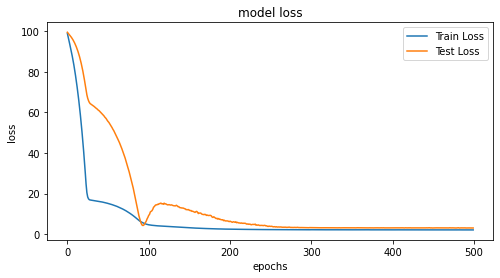

In [37]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [27]:
import seaborn as sns

In [38]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(1128,1250)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

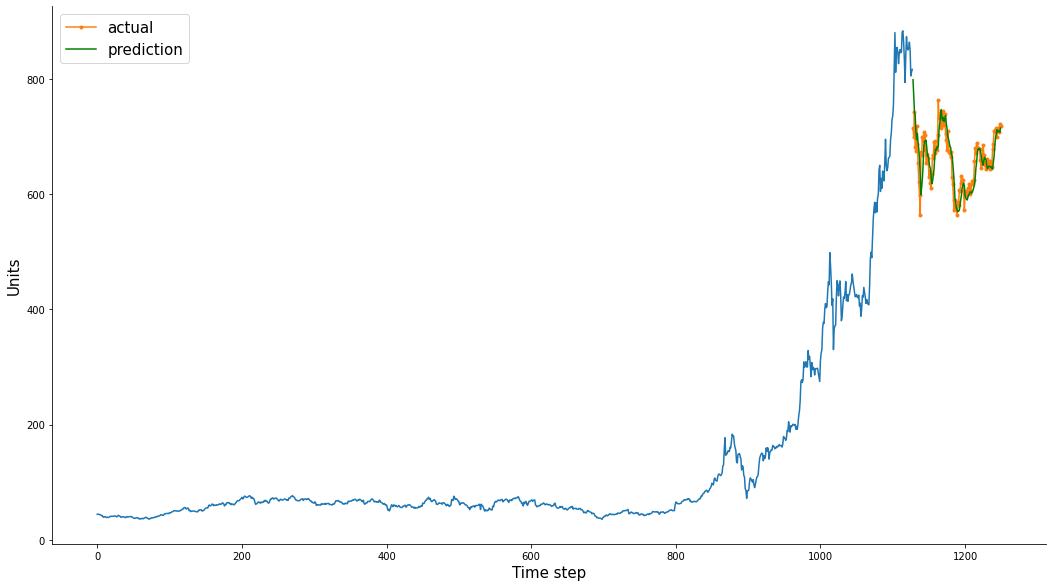

In [39]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)